In [1]:

! pip install scanpy
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

     |████████████████████████████████| 2.0 MB 5.4 MB/s 
     |████████████████████████████████| 127 kB 23.6 MB/s 
     |████████████████████████████████| 80 kB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 56.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=a53df79a753eada7702f72ee07ee99255f8be64002a9d01795da45e2fe07cadc
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=586fcd8ac13b4c620fb7411911420e6ef39b73c9c90d0af03f68c1c82c6af9b1
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=baeeb22618dc6342f2750721bfc7d5ef95cd0d6c6cd24e632630f9652193b436
  Stored in directory: /root/.cache/

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc

In [5]:
sc.settings.verbosity = 3 # errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 pynndescent==0.5.4


In [6]:
results_file = 'write/pbmc3k.h5ad'

In [7]:
# read the data into an AnnData format
adata = sc.read_10x_mtx(
            'data/filtered_gene_bc_matrices/hg19/',
            var_names='gene_symbols',
            cache=True
)

... writing an h5ad cache file to speedup reading next time


In [9]:
adata.var_names_make_unique() #unnecessary if using var_names = 'gene_ids' in sc.read_10x_mtx
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Typical Workflow

1. Show genes that yield the highest fraction of counts in each single cell, across all cells

2. Basic filtering

3. Info on mito genes for QC

  a) # of genes expressed in the count matrix

  b) total counts/cell

  c) % of counts in mito genes

4. Log the data

5. Identify highly-variable genes

6. Regress out effects of total counts/cell and the % of mito genes expressed. Scale the data to unit variance

7. PCA

  a) inspect contribution of single PCs to the total variance -> info about how many PCs we should consider in order to compute the neighborhood relations of cells

8. Computing the neighborhood graph

9. Embedding the neighborhood graph

  a) Use UMAP as it's potentially more powerful to the global connectivity of the manifold than tSNE i.e. better preserves trajectories

  b) in some occassions, you might still observe disconnected clusters and similar connectivity violations

10. Clustering the neigborhood graph

  a) recommend the Leiden graph-clustering method

11. Finding marker genes

  a) ranking for the highly differential genes in each cluster

      i) Wilcoxon rank-sum (Mann-Whitney-U) test

      ii) logistic regression

  b) mark the cell types

  c) visualize the marker genes



## Preprocessing

normalizing counts per cell
    finished (0:00:00)


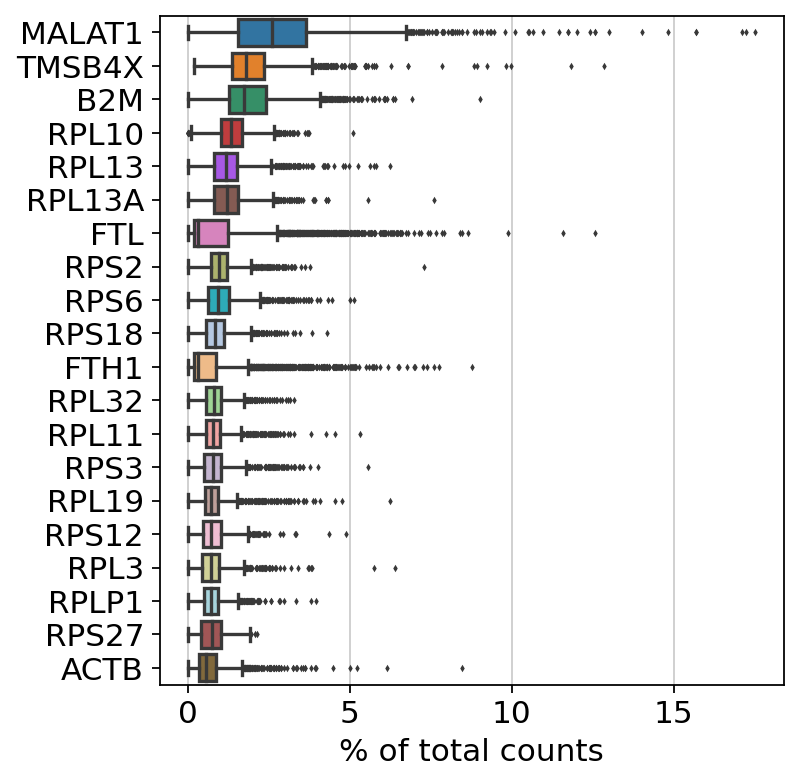

In [10]:
# genes that yield highest fraction of counts in each single cell, across all cells

sc.pl.highest_expr_genes(adata, n_top=20,)

In [11]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [12]:
# remove mito genes
# reason: high proportions are indicative of poor-quality cells, possibly because of loss of cytoplasmic RNA
# from perforated cells. The reasoning is that mito are larger than individual transcript molecules and less likely to escape through tears in the cell membrane

adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=None, inplace=True)

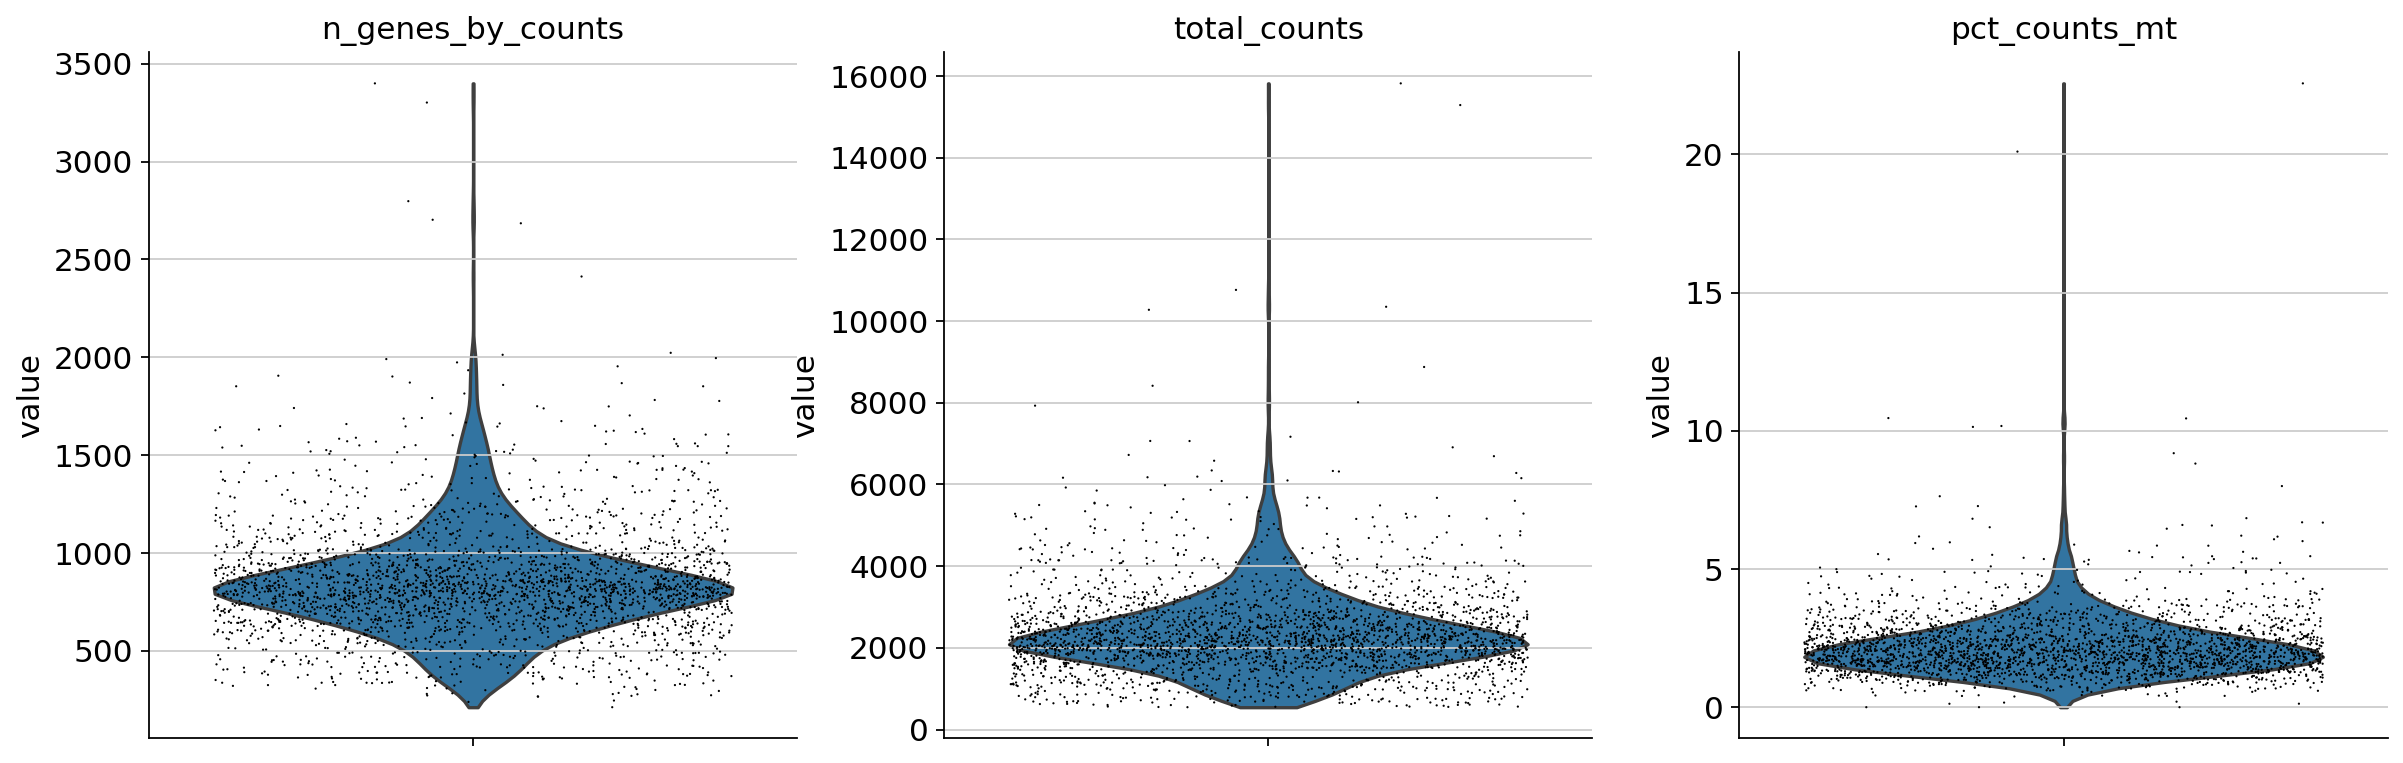

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

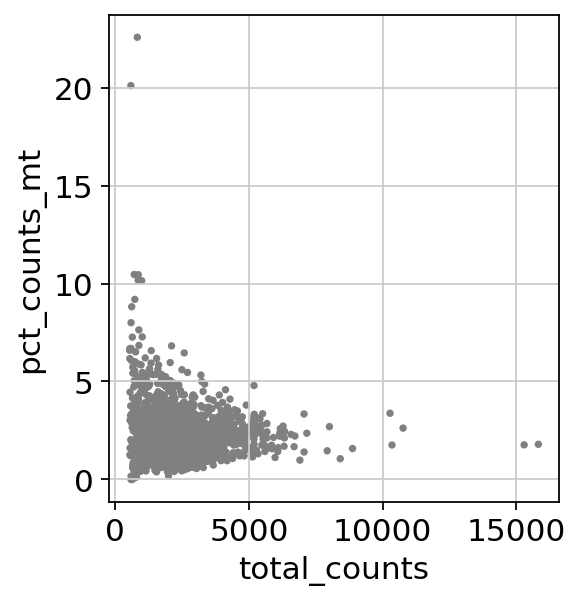

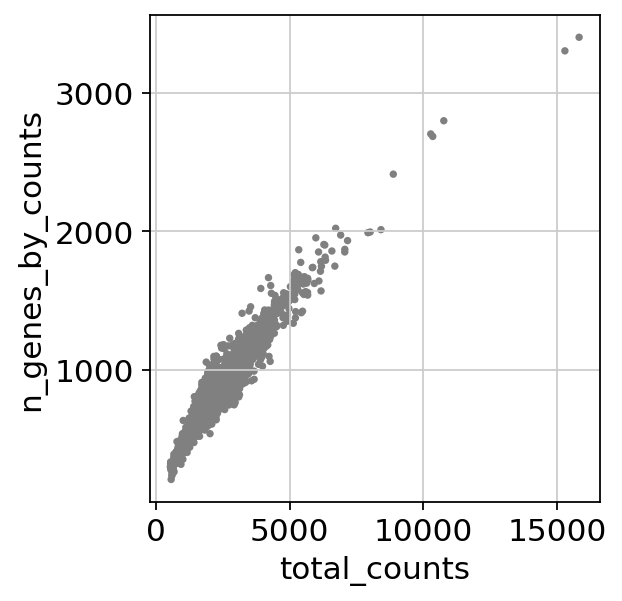

In [14]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
sc.pp.log1p(adata)

In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


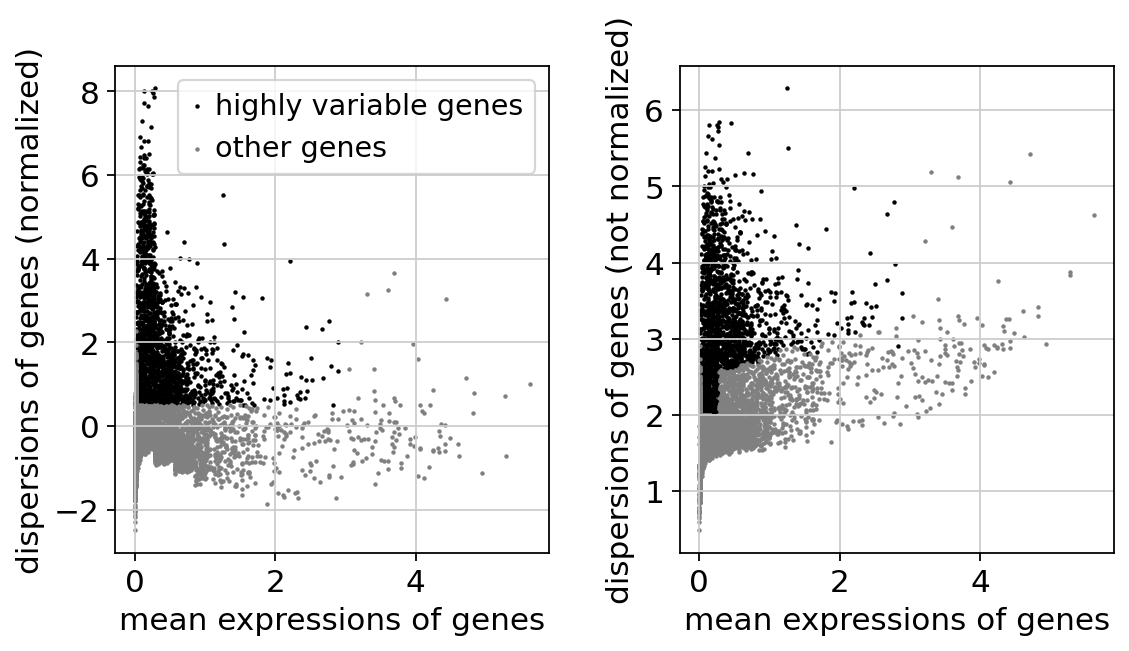

In [20]:
sc.pl.highly_variable_genes(adata)

In [21]:
adata.raw = adata

In [22]:
adata = adata[:, adata.var.highly_variable]

In [23]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:10)


In [24]:
sc.pp.scale(adata, max_value=10)

## PCA

In [25]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


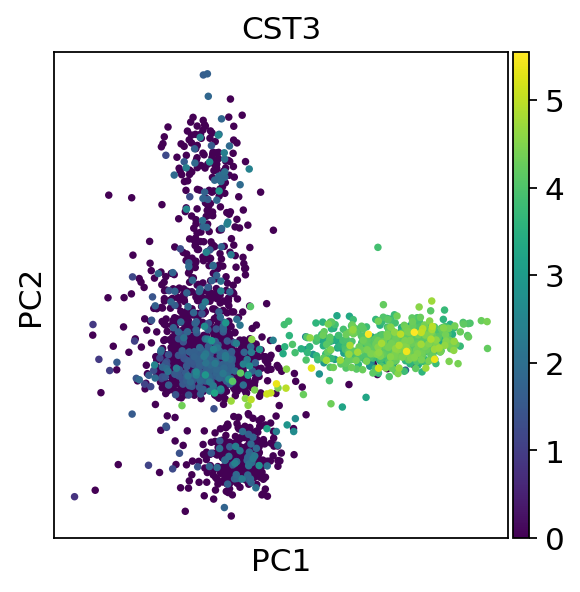

In [26]:
sc.pl.pca(adata, color='CST3')

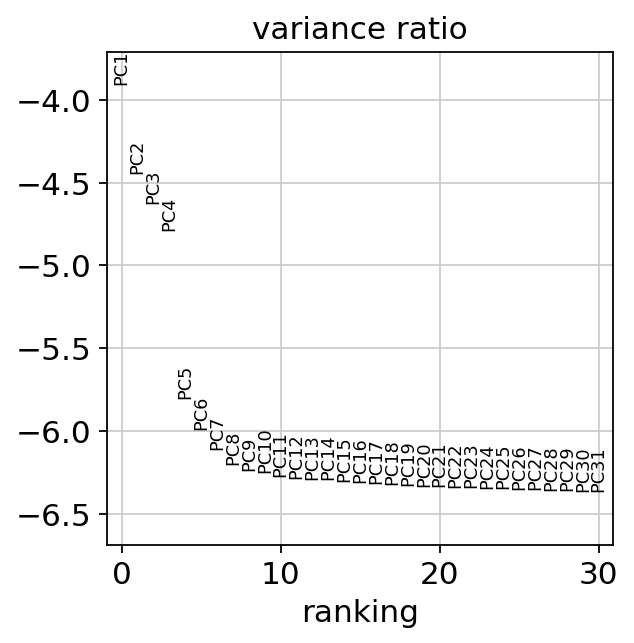

In [27]:
sc.pl.pca_variance_ratio(adata, log=True)

In [28]:
adata.write(results_file)

In [29]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [30]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


## Embedding the neighborhood graph

In [32]:
# tl.paga(adata)
# pl.paga(adata, plot=False)
# tl.umap(adata, init_pos='paga')

sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


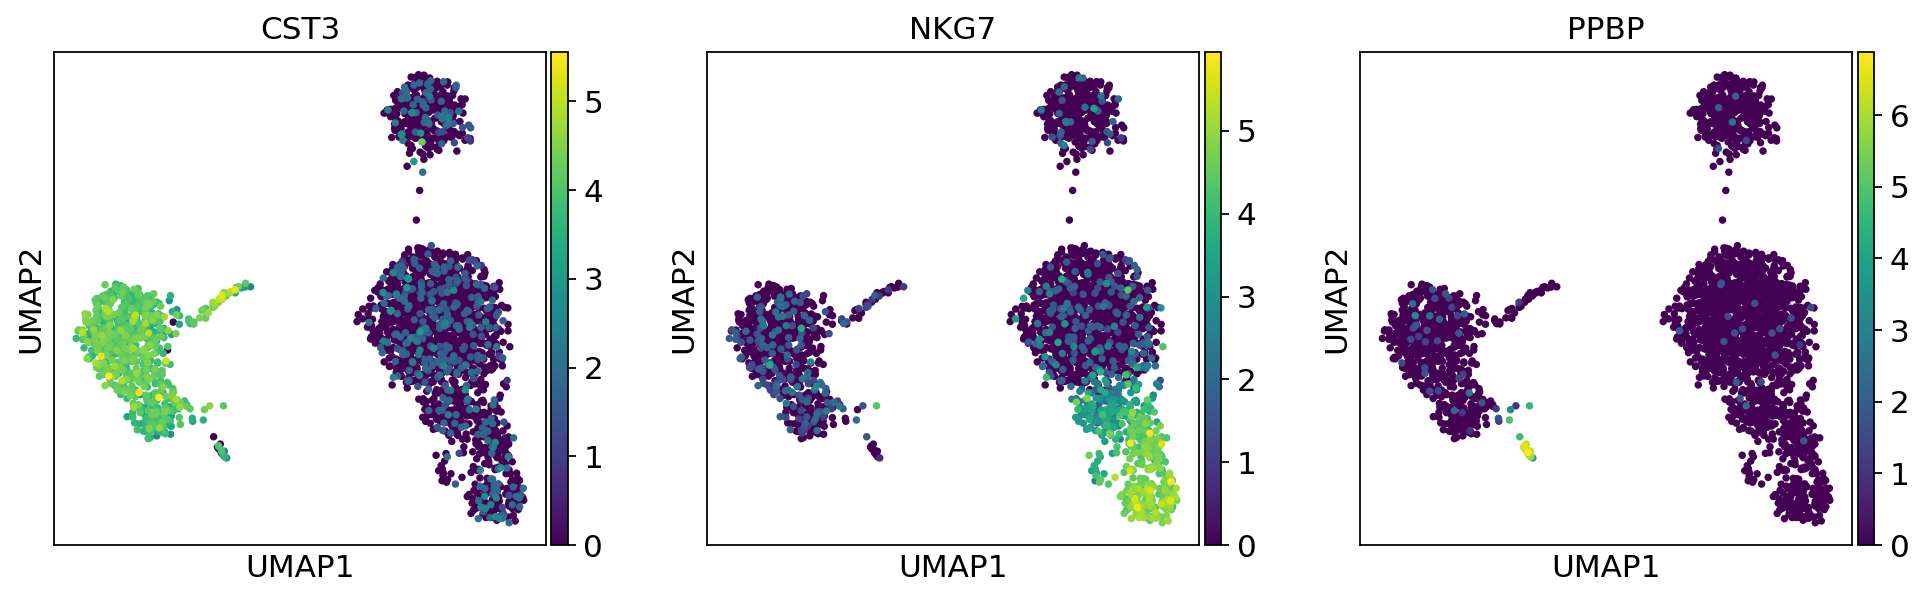

In [33]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

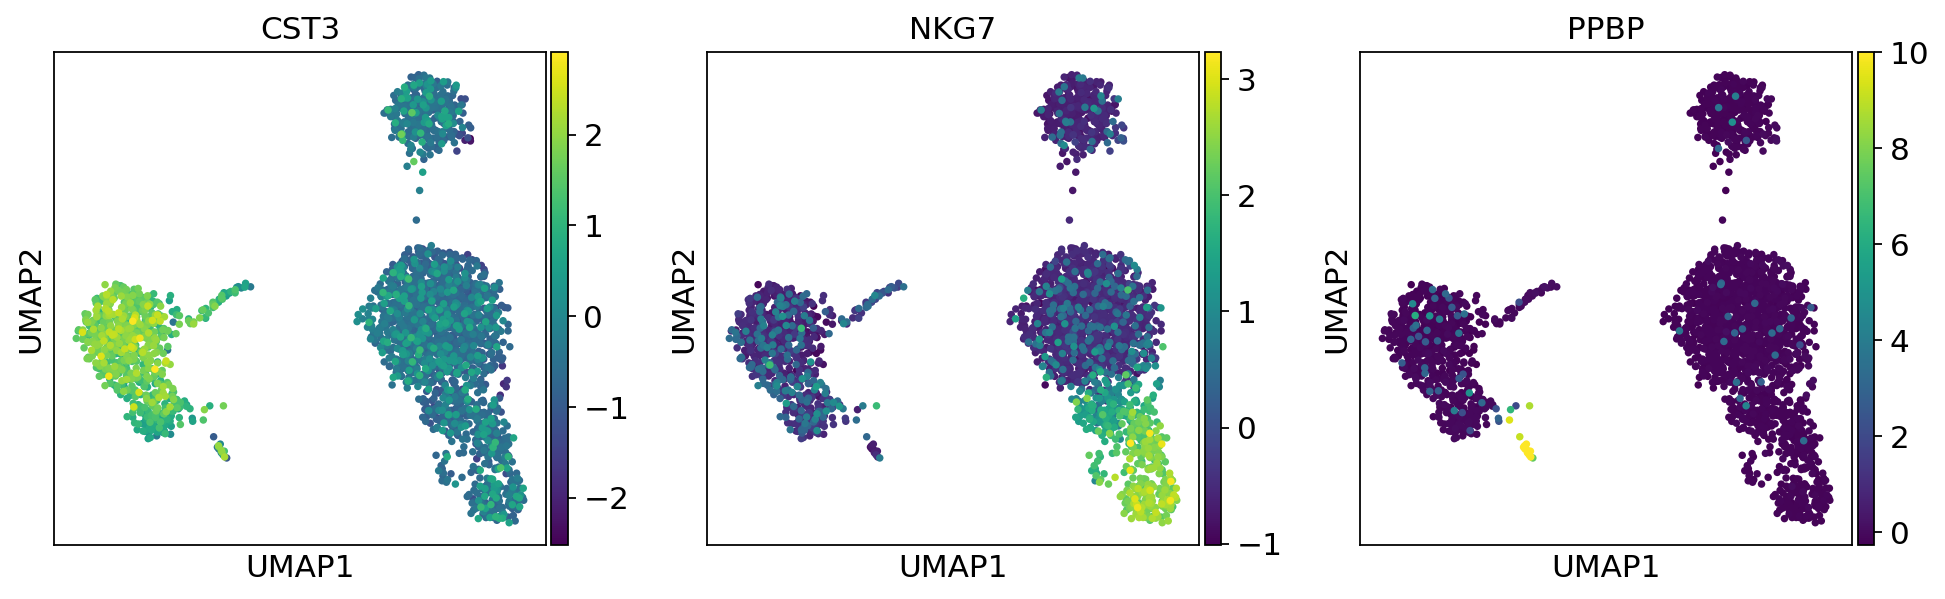

In [36]:
# use the non-raw data
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

In [38]:
! pip install leidenalg

     |████████████████████████████████| 1.4 MB 5.6 MB/s 
     |████████████████████████████████| 3.2 MB 29.1 MB/s 


In [39]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


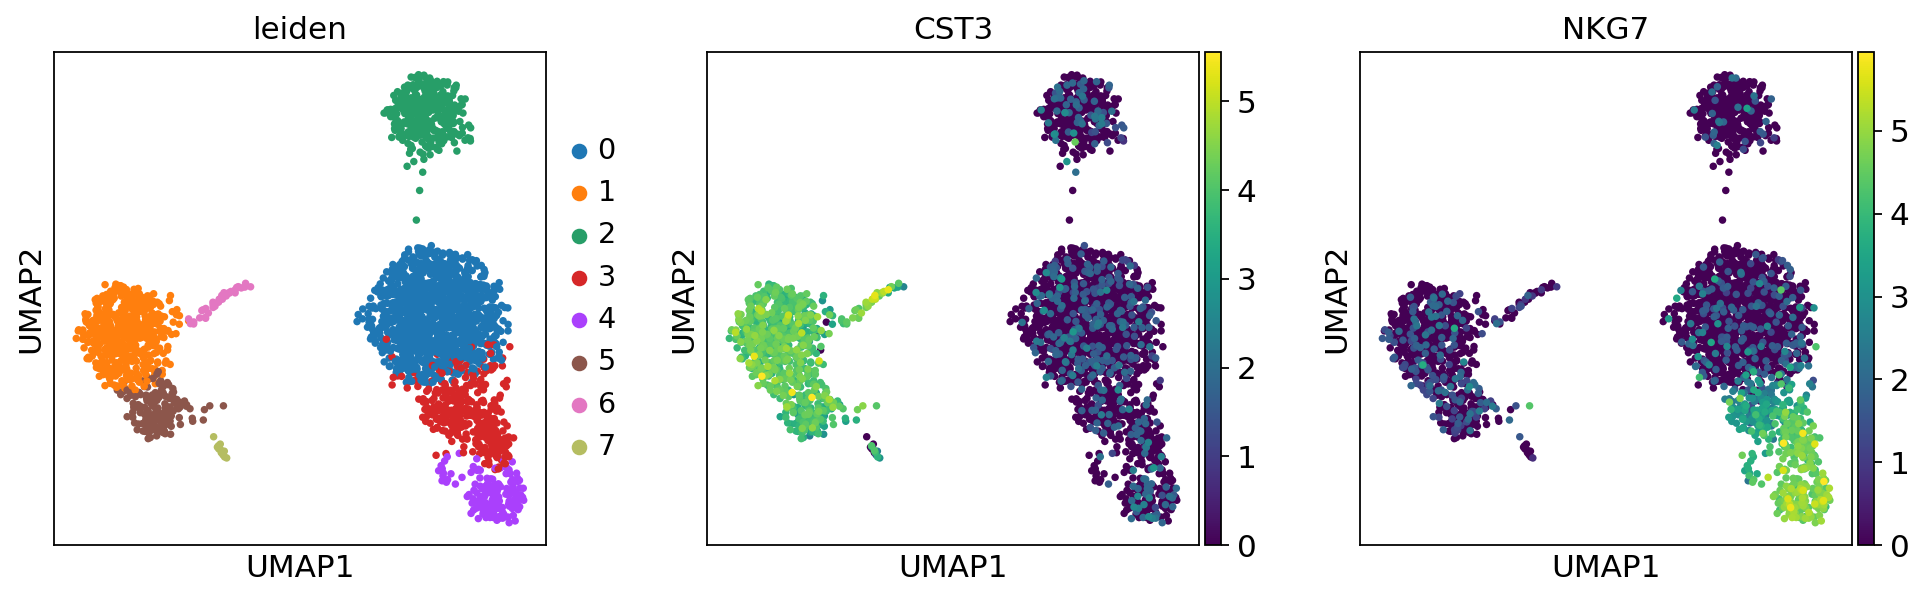

In [40]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [41]:
adata.write(results_file)

## Finding marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


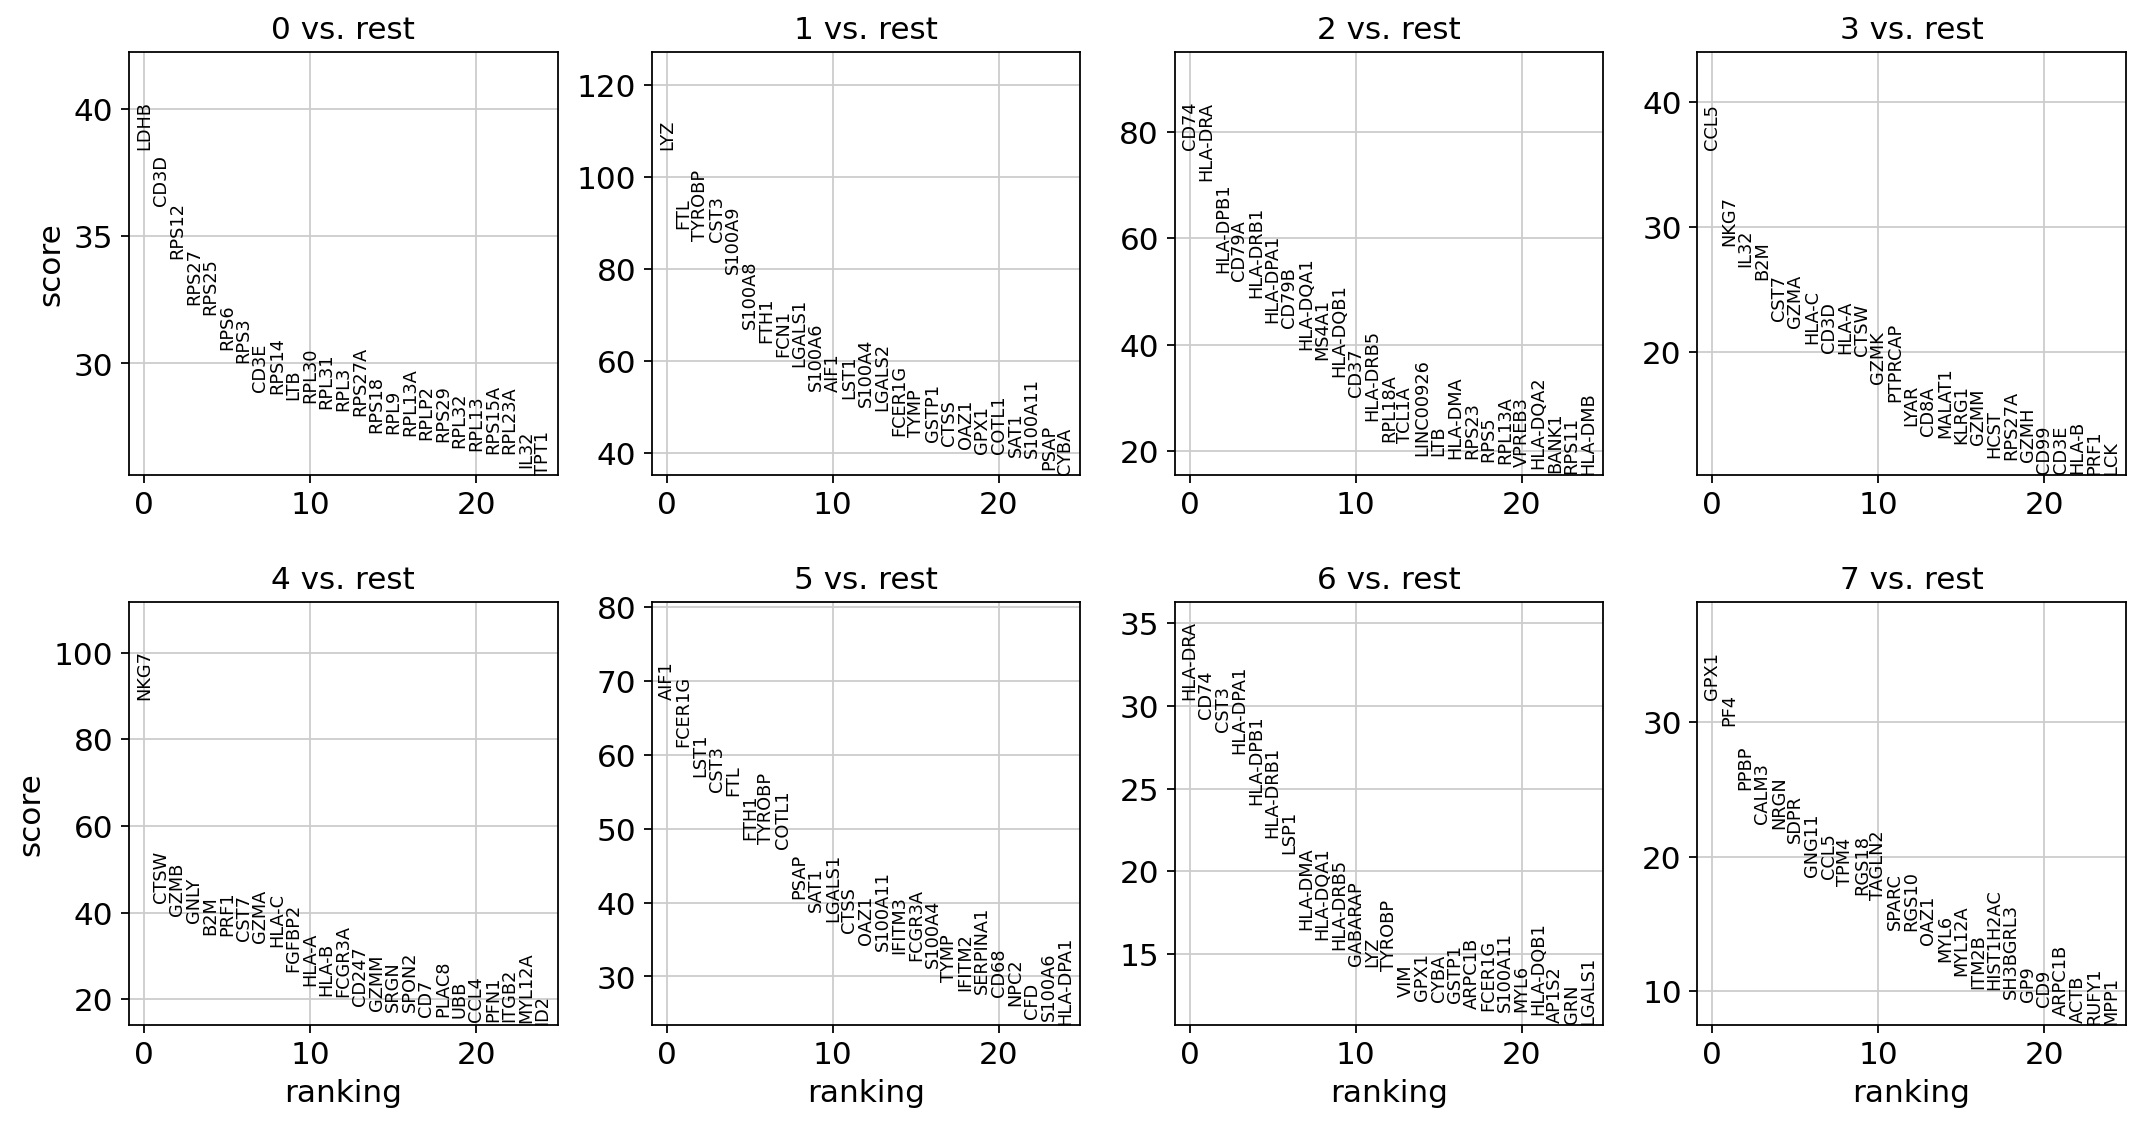

In [42]:
# highly variable genes

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

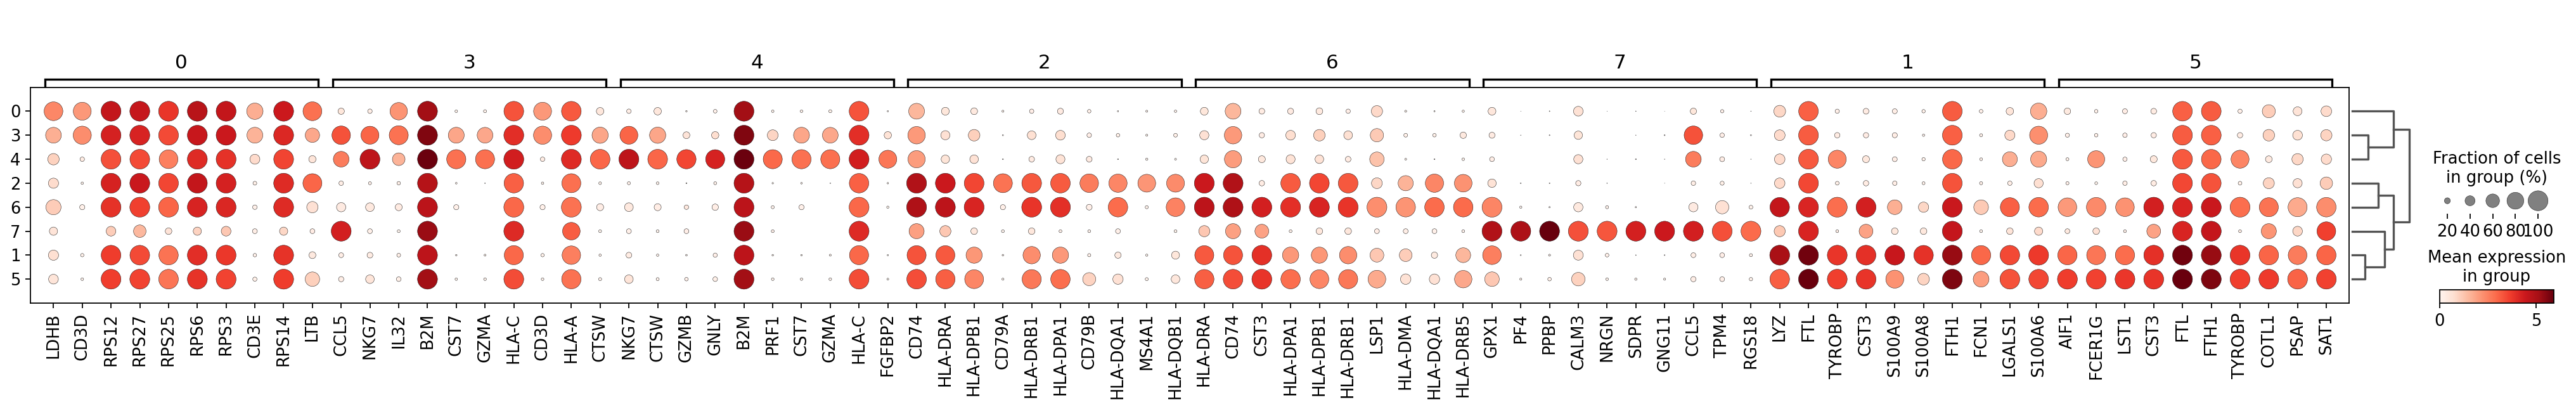

In [44]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10)

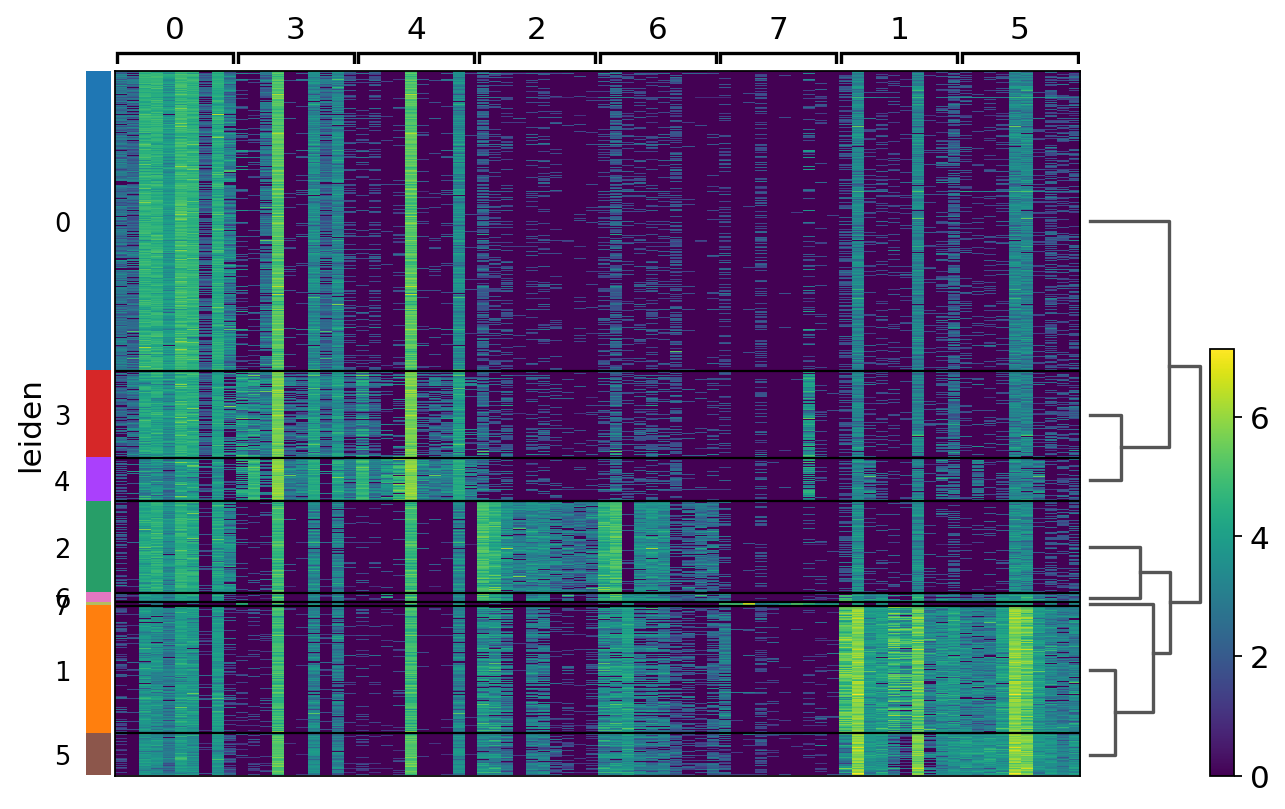

In [45]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10)

In [46]:
sc.settings.verbosity = 2

ranking genes
    finished (0:00:02)


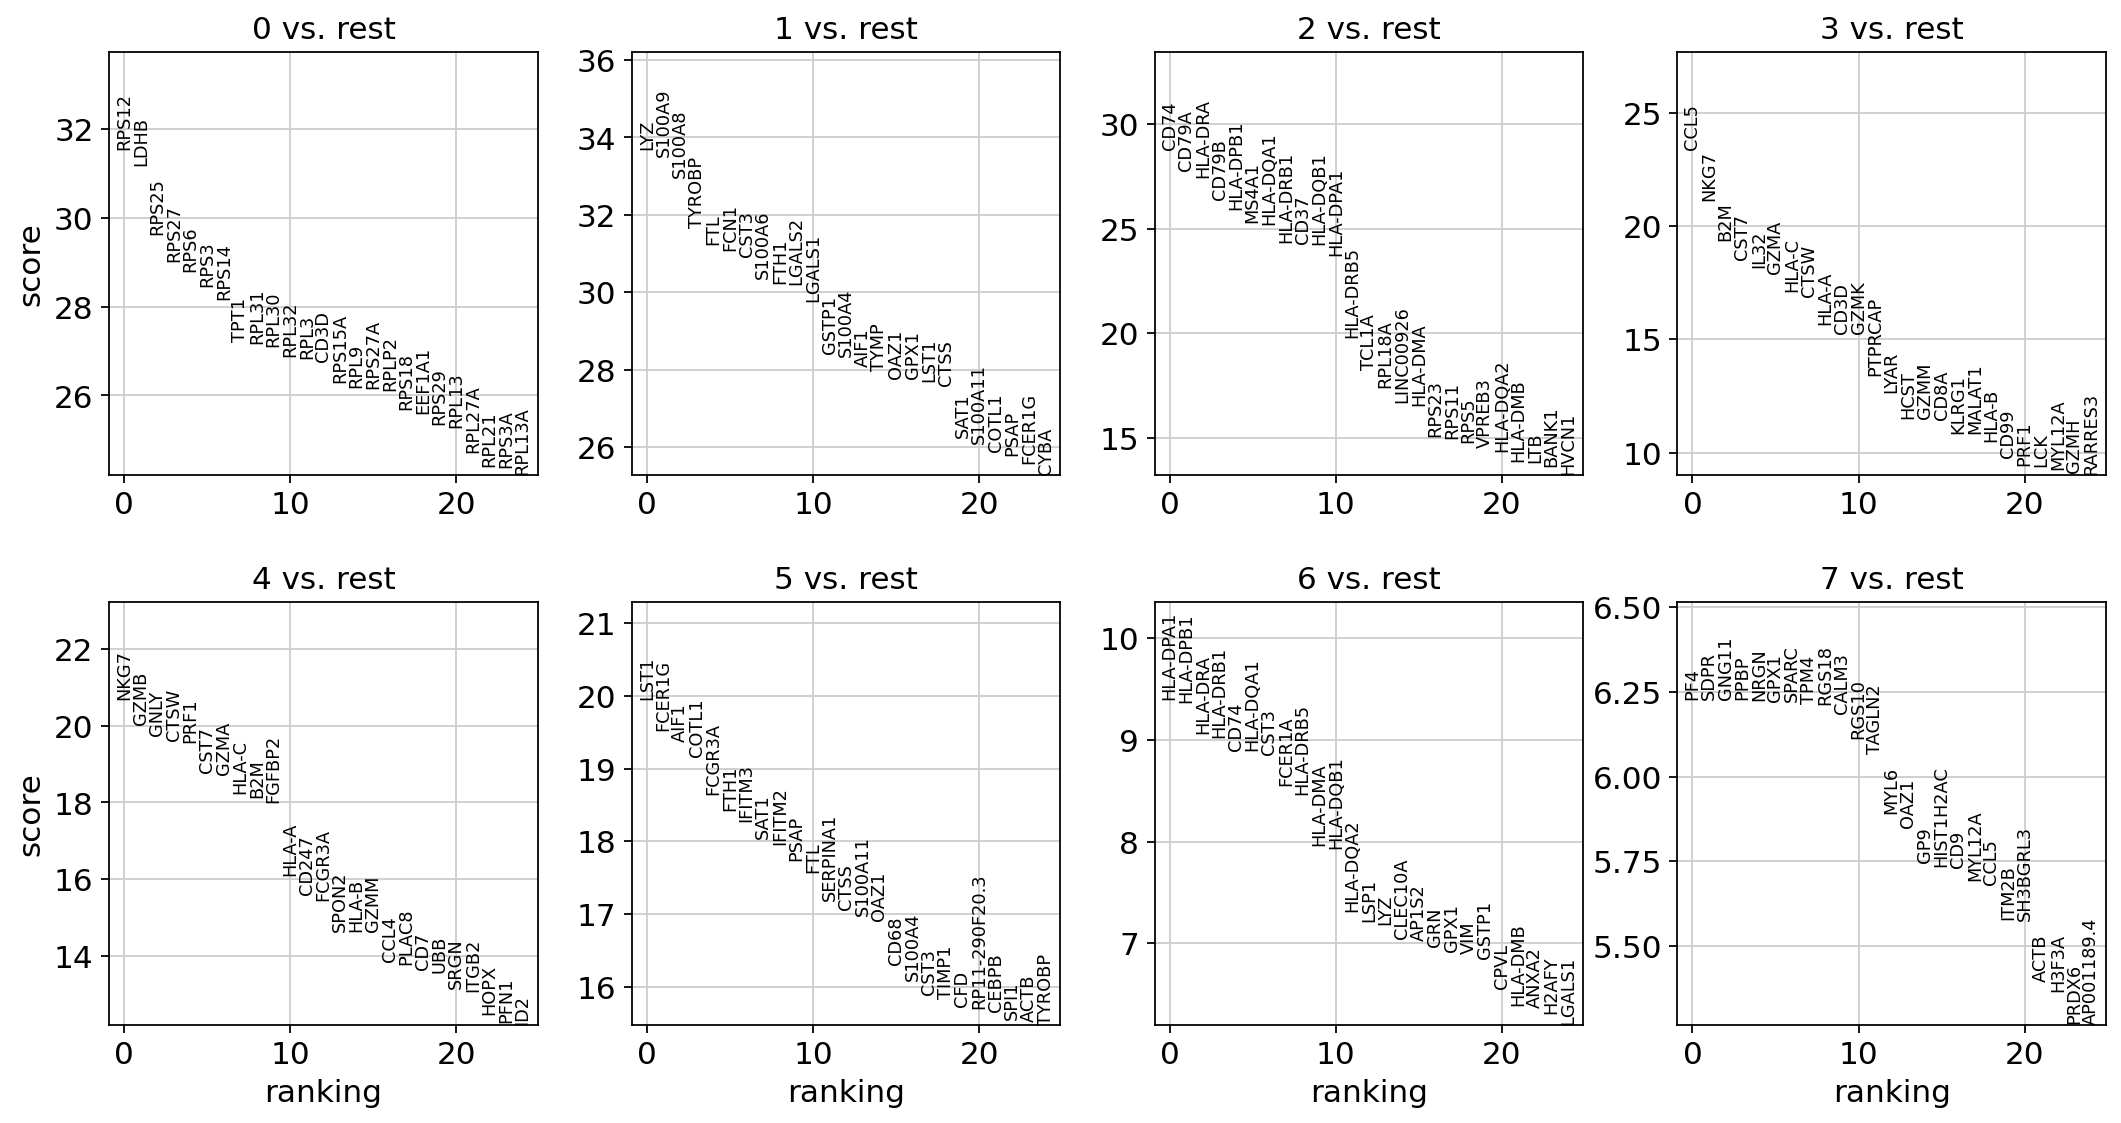

In [47]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [48]:
adata.write(results_file)

ranking genes
    finished (0:00:14)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


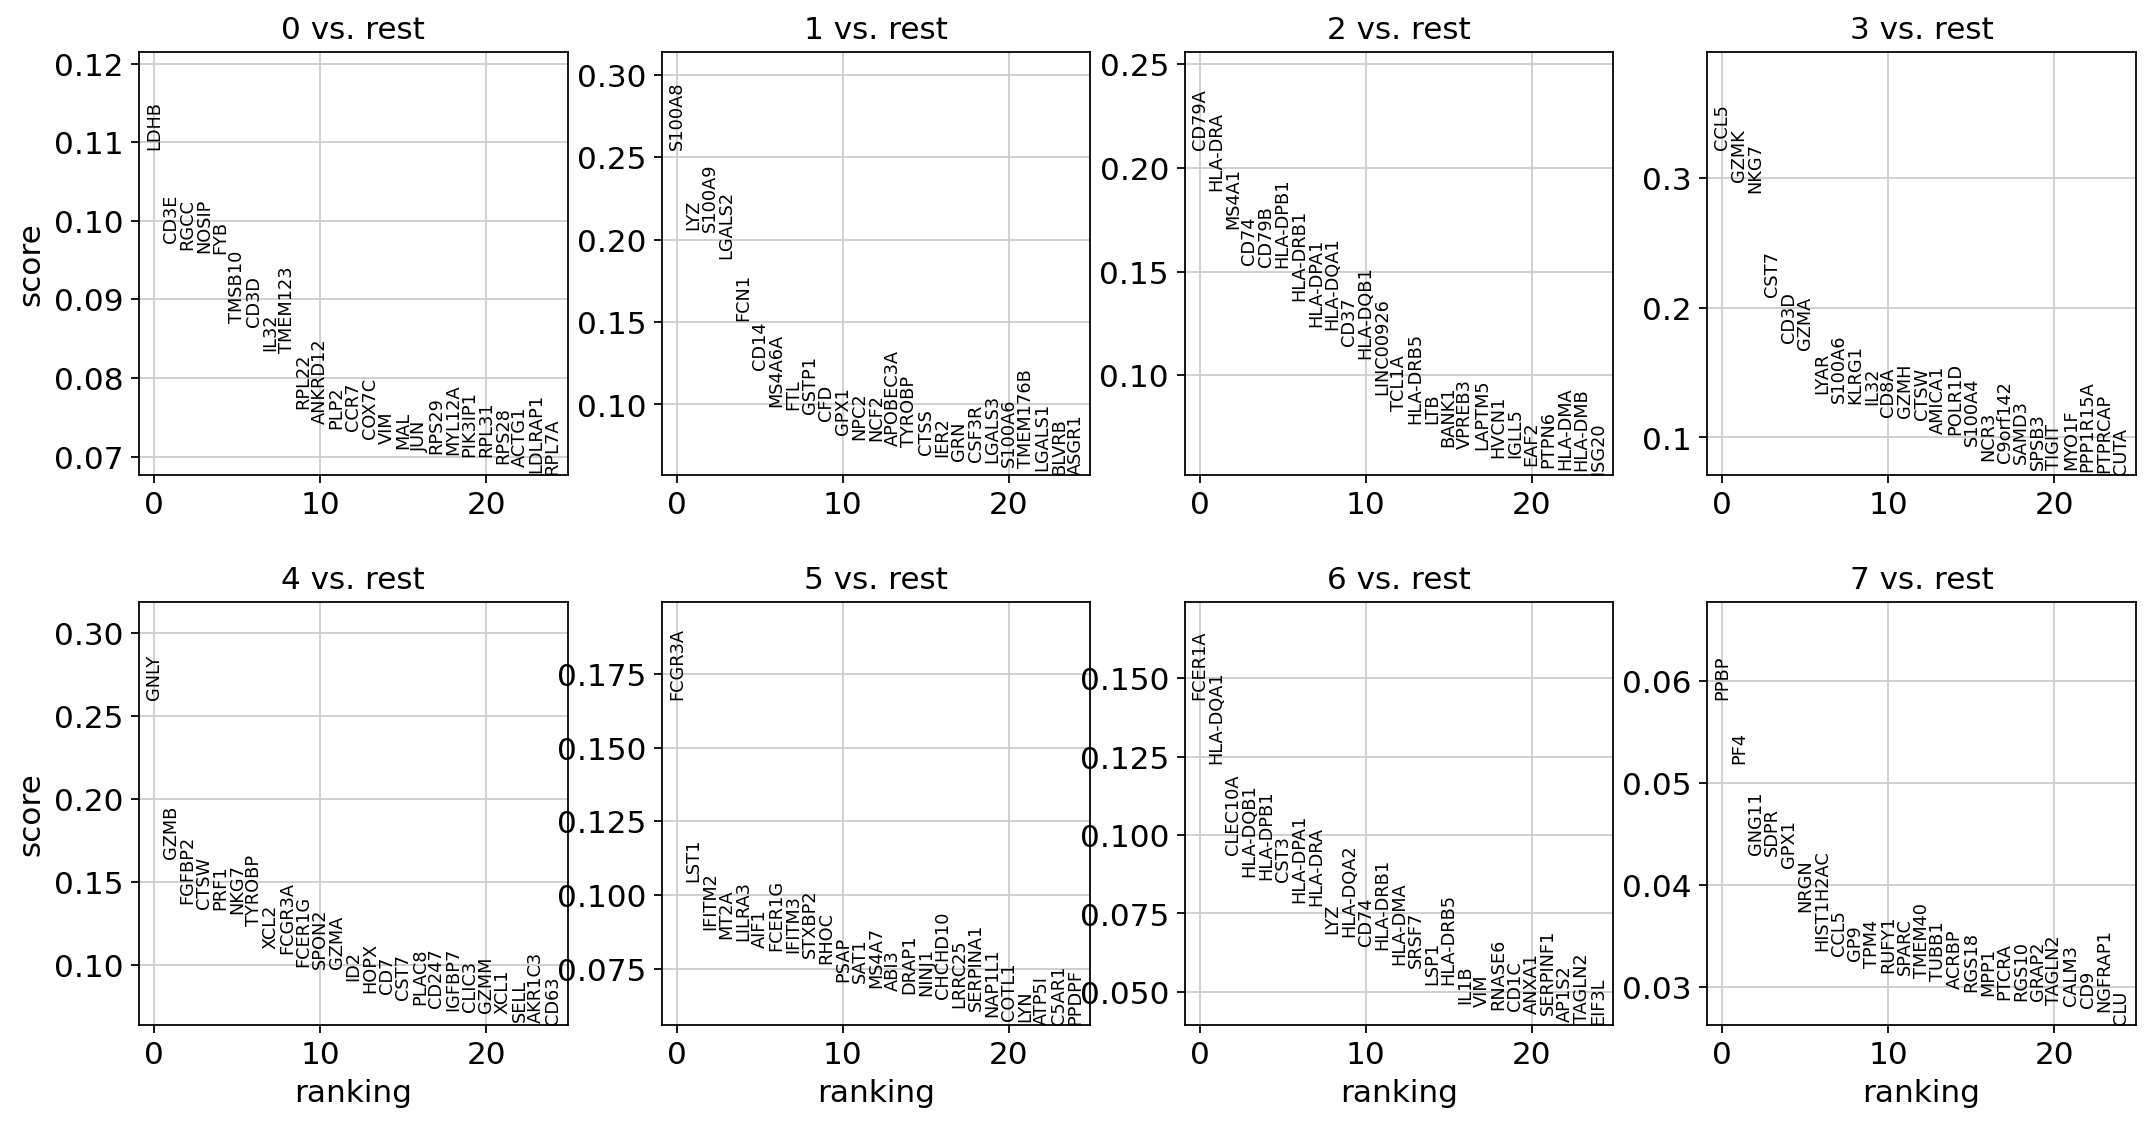

In [49]:
# logistc regression
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [50]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [51]:
adata = sc.read(results_file)

In [52]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1         2     3     4       5         6      7
0  RPS12     LYZ      CD74  CCL5  NKG7    LST1  HLA-DPA1    PF4
1   LDHB  S100A9     CD79A  NKG7  GZMB  FCER1G  HLA-DPB1   SDPR
2  RPS25  S100A8   HLA-DRA   B2M  GNLY    AIF1   HLA-DRA  GNG11
3  RPS27  TYROBP     CD79B  CST7  CTSW   COTL1  HLA-DRB1   PPBP
4   RPS6     FTL  HLA-DPB1  IL32  PRF1  FCGR3A      CD74   NRGN

In [54]:
# get a table w/ the scores and groups
results = adata.uns['rank_genes_groups']
groups = results['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: results[key][group]
     for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n  ...           6_p    7_n           7_p
0  RPS12  1.877956e-218     LYZ  ...  5.422417e-21    PF4  4.722886e-10
1   LDHB  1.782734e-213  S100A9  ...  7.591860e-21   SDPR  4.733899e-10
2  RPS25  5.870126e-193  S100A8  ...  1.306768e-19  GNG11  4.733899e-10
3  RPS27  3.927448e-185  TYROBP  ...  1.865104e-19   PPBP  4.744938e-10
4   RPS6  3.232888e-182     FTL  ...  5.853161e-19   NRGN  4.800511e-10

[5 rows x 16 columns]

ranking genes
    finished (0:00:01)


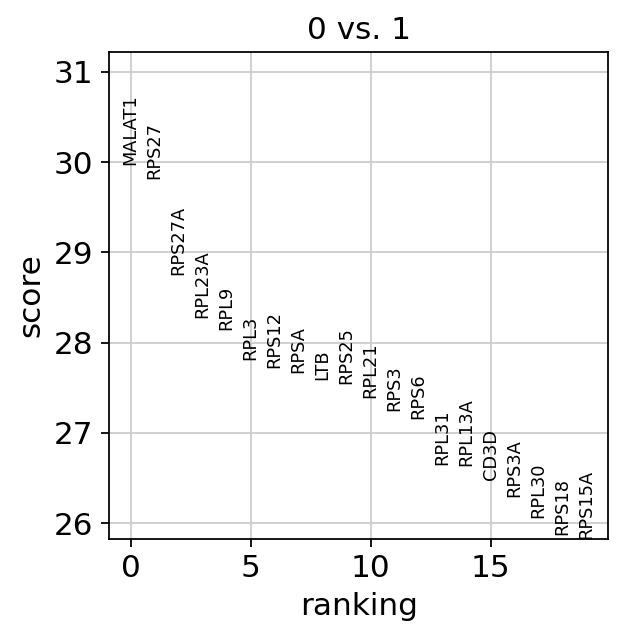

In [55]:
# compare to a single cluster
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference = '1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

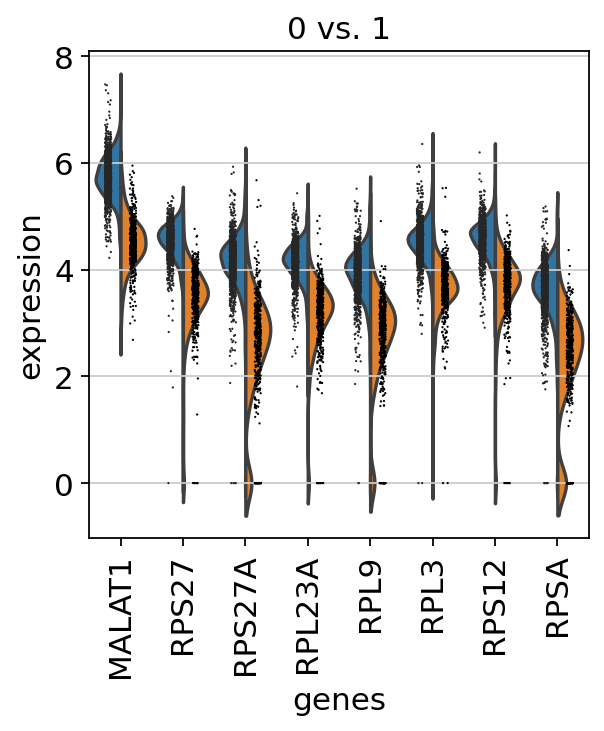

In [56]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

ranking genes
    finished (0:00:00)


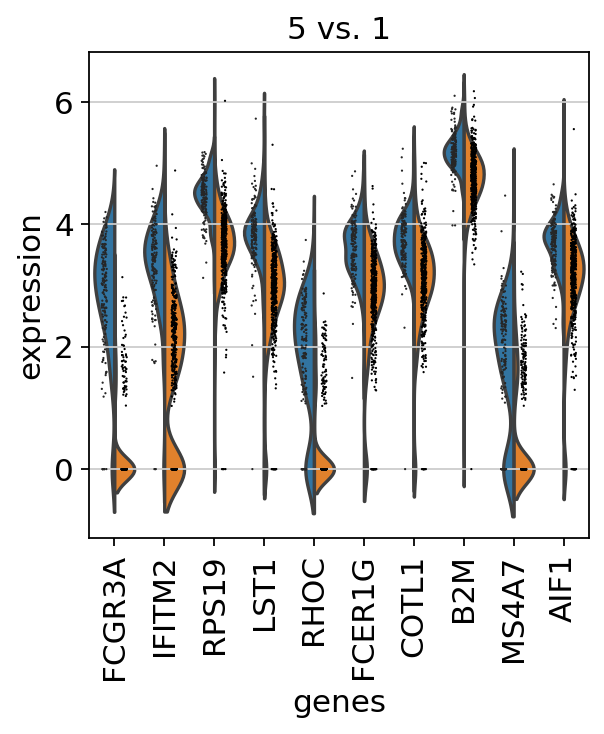

In [61]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['5'], reference = '1', method='wilcoxon')
sc.pl.rank_genes_groups_violin(adata, groups='5', n_genes=10)

In [62]:
adata = sc.read(results_file)

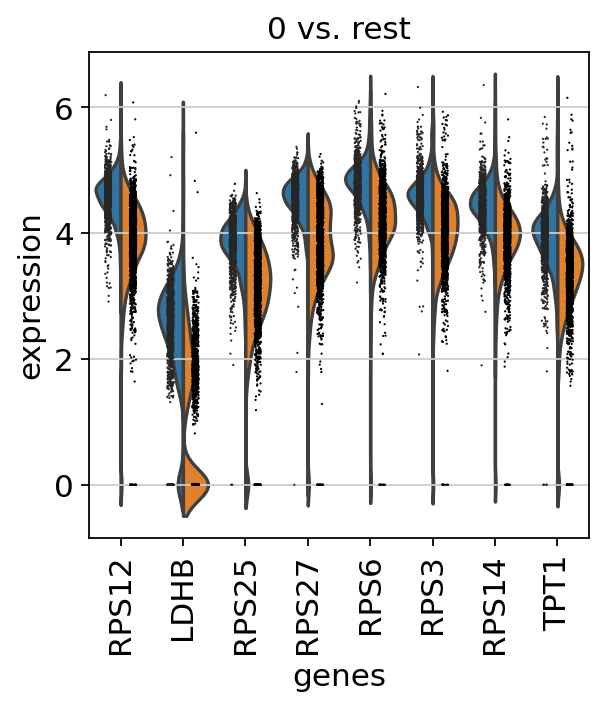

In [63]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

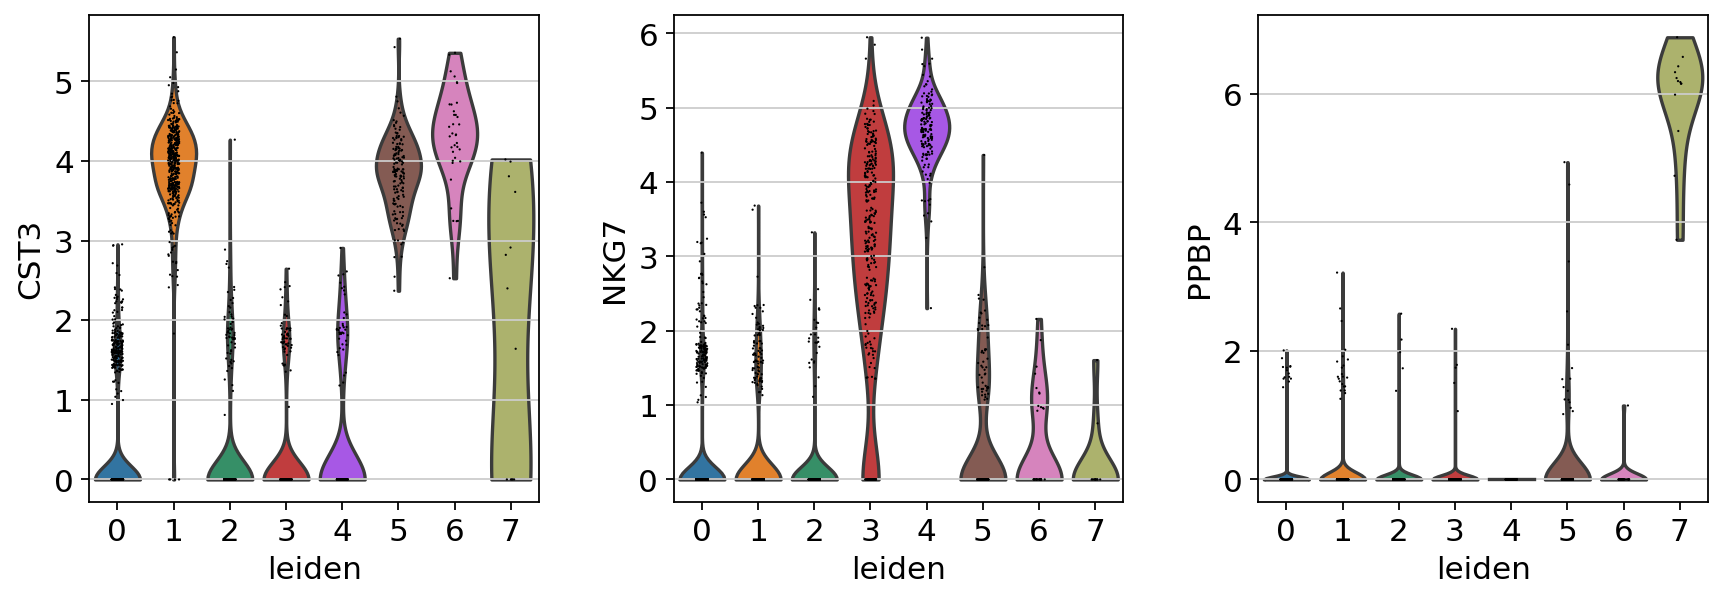

In [64]:
# compare a certain gene across groups
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [65]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

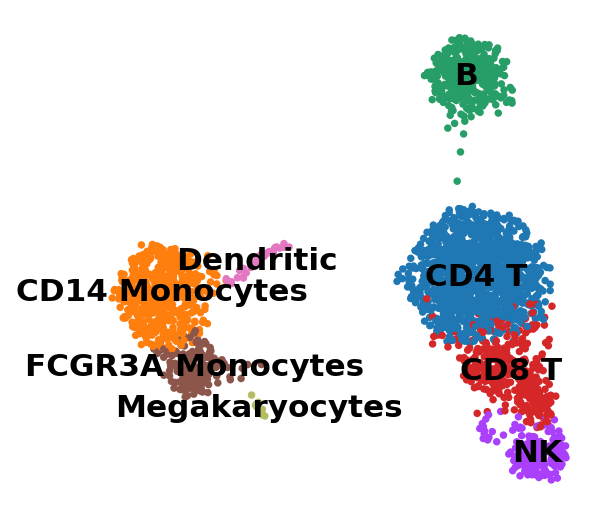

In [66]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

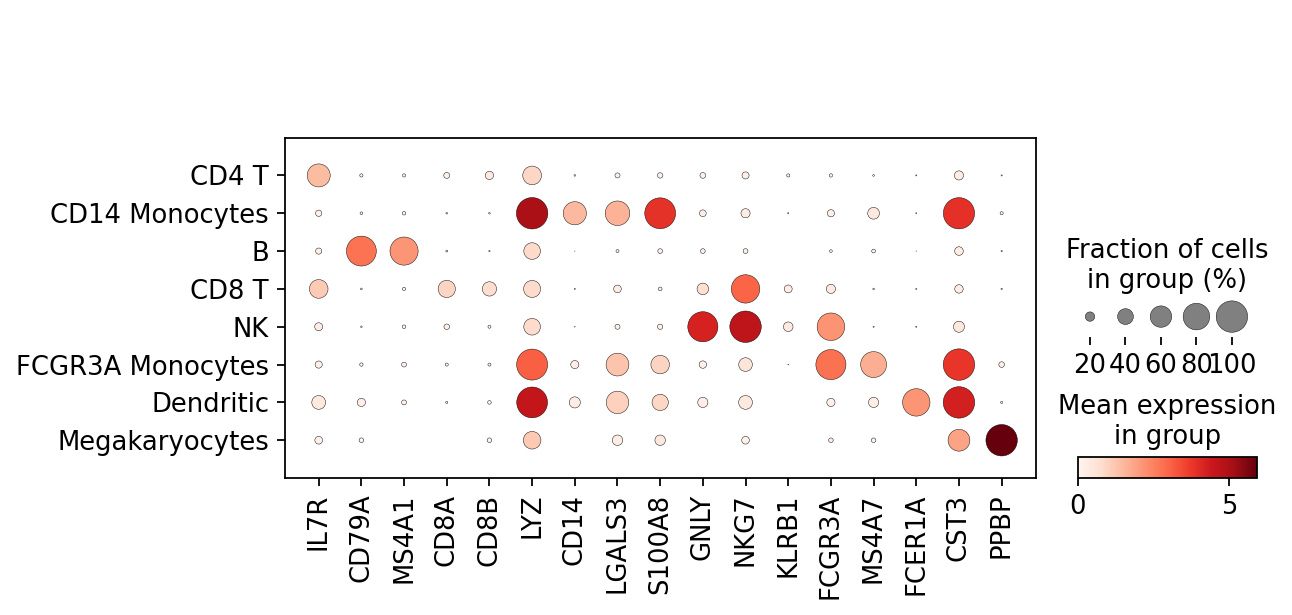

In [67]:
# now that we annotated the cell types, visualize the marker genes
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

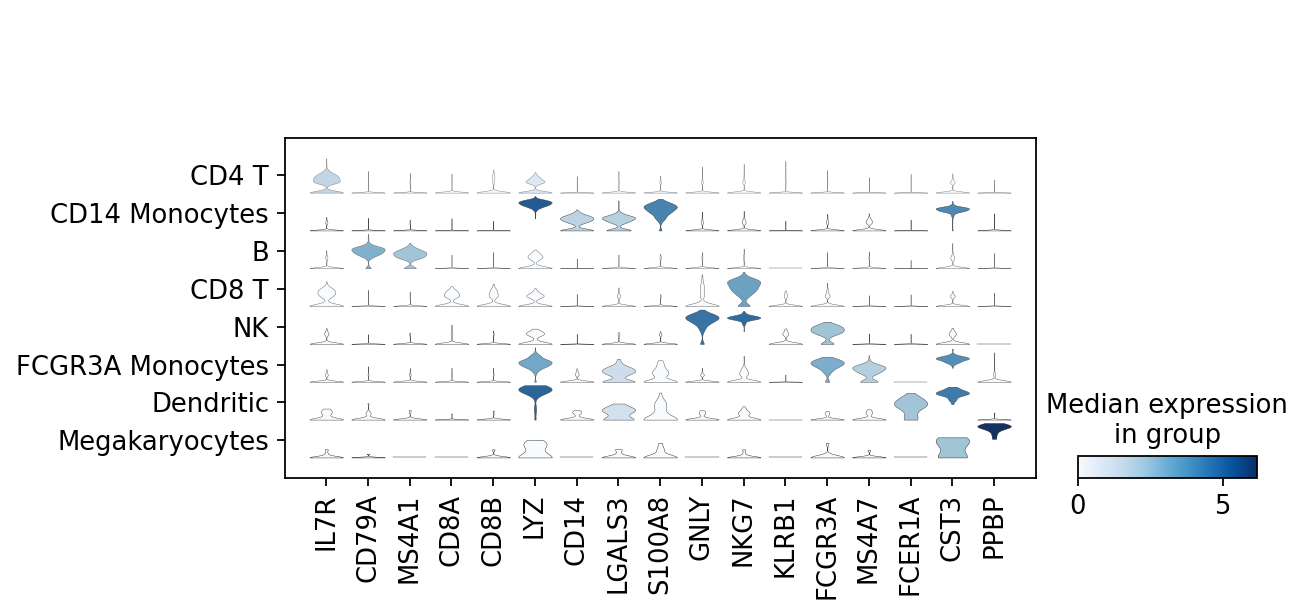

In [68]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

In [69]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
# save w/ compression to save space
adata.write(results_file, compression='gzip')

# share file: to reduce the file size by removing the dense scaled and corrected data matrix
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

# export to csv
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )